# Downloading the data (for colab)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bmodel","key":"3f47b88f9407611d83b49b05ed30373d"}'}

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip -q gtzan-dataset-music-genre-classification.zip
!mv Data data
!mv data/genres_original data/audio

# jazz.00054.wav is corrupted so we need to delete it
!rm ./data/audio/jazz/jazz.00054.wav

100% 1.21G/1.21G [00:35<00:00, 37.8MB/s]
100% 1.21G/1.21G [00:36<00:00, 36.1MB/s]


In [4]:
!pip install -q pydub
!pip install -q transformers
!pip install -q tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 14.6 MB/s eta 0:00:00


# Processing data
Available at https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [1]:
import os
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from pydub import AudioSegment

import torch
from torch import nn
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio

from sklearn.manifold import TSNE

# Pretrained audio spectograph transformer
from transformers import ASTModel, AutoFeatureExtractor, AutoProcessor

# from tqdm import tqdm_notebook, tqdm
from tqdm.notebook import tqdm

In [2]:
AUDIO_ROOT = './data/audio'
SPLIT_AUDIO_ROOT = './data/samples'
SAMPLE_LENGTH_MS = 5000 # All audio samples are 30 seconds long -> each sample can be 6 points

## Helpers for loading and transforming the data

In [7]:
# Split audio into SAMPLE_LENGTH_MS segments
try:
  os.mkdir(SPLIT_AUDIO_ROOT)
except:
  pass
for dirent in os.listdir(AUDIO_ROOT):
    dirpath = os.path.join(AUDIO_ROOT, dirent)
    if os.path.isdir(dirpath):
        try:
          os.mkdir(os.path.join(SPLIT_AUDIO_ROOT, dirent))
        except:
          pass

        for file in os.listdir(dirpath):
            if file == '.DS_Store':
                continue
                
            path = os.path.join(dirpath, file)
            audio = AudioSegment.from_wav(path)
            
            total_ms = int(audio.duration_seconds) * 1000
            for start_ms in range(0, total_ms, SAMPLE_LENGTH_MS):
                end_ms = start_ms + SAMPLE_LENGTH_MS
                split = audio[start_ms:end_ms]
                
                split_filename = os.path.join(SPLIT_AUDIO_ROOT, dirent, f"{start_ms}_{file}")
                split.export(split_filename, format="wav")

In [25]:
files = []
labels = []
for dirent in os.listdir(SPLIT_AUDIO_ROOT):
    dirpath = os.path.join(SPLIT_AUDIO_ROOT, dirent)
    if os.path.isdir(dirpath):
        for file in os.listdir(dirpath):
            if file == '.DS_Store':
                continue
            path = os.path.join(dirpath, file)
            files.append(path)
            labels.append(dirent)

dataframe = pd.DataFrame({'file': files, 'label': labels})
dataframe['labelId'] = dataframe.groupby('label', sort=False).ngroup()
dataframe

,file,label,labelId
0,./data/samples/pop/10000_pop.00041.wav,pop,0
1,./data/samples/pop/10000_pop.00055.wav,pop,0
2,./data/samples/pop/10000_pop.00069.wav,pop,0
3,./data/samples/pop/10000_pop.00082.wav,pop,0
4,./data/samples/pop/20000_pop.00018.wav,pop,0
...,...,...,...
5989,./data/samples/jazz/5000_jazz.00033.wav,jazz,9
5990,./data/samples/jazz/5000_jazz.00027.wav,jazz,9
5991,./data/samples/jazz/20000_jazz.00039.wav,jazz,9
5992,./data/samples/jazz/20000_jazz.00005.wav,jazz,9


In [26]:
class AudioHelper():
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    # Convert into 2-channel
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return ((resig, sr))

    # Since Resample applies to a single channel, we resample one channel at a time
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
          # Nothing to do
          return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)

In [27]:
# TODO: Add a data augmentation to pitch up and down since it doesn't change genre just the key
class AudioTransformations():
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # Generate a Mel Spectrogram 
    # It converts the audio file into a format that is more similar to how humans actually percieve audio
    @staticmethod
    def spectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

    
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    @staticmethod
    def spectrogram_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

## Visualizers

In [28]:
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#preparing-data-and-utility-functions-skip-this-section
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

## Creating PyTorch data loader

In [29]:
# Feature extractor for pretrained model
# feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
# processor = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
feature_extractor = AutoFeatureExtractor.from_pretrained("bookbot/distil-ast-audioset")
processor = AutoProcessor.from_pretrained("bookbot/distil-ast-audioset")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [30]:
class AudioDS(Dataset):
    def __init__(self, df, pretrained=False, inference=False):
        self.df = df
        self.duration = 4000 # Truncating all audio clips to 4 seconds
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
        self.pretrained = pretrained
        self.inference = inference

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'file']

        if not self.inference:
            class_id = self.df.loc[idx, 'labelId']
        
        # Use pretrained data preprocessor if we are using transfer learning
        if self.pretrained:
            audio, sr = librosa.load(audio_file, sr=feature_extractor.sampling_rate)
            
            # Funny business to get the shape to work correctly
            pretrained_feat = processor(audio, sampling_rate=sr, return_tensors="pt")
            feat_shape = pretrained_feat['input_values'].shape
            pretrained_feat['input_values'] = pretrained_feat['input_values'].view(feat_shape[1], feat_shape[2])
            
            if not self.inference:
                return pretrained_feat, class_id
            return pretrained_feat

        aud = AudioHelper.open(audio_file)
        reaud = AudioHelper.resample(aud, self.sr)
        rechan = AudioHelper.rechannel(reaud, self.channel)
        dur_aud = AudioHelper.pad_trunc(rechan, self.duration)
        
        shift_aud = AudioTransformations.time_shift(dur_aud, self.shift_pct)
        sgram = AudioTransformations.spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioTransformations.spectrogram_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        if not self.inference:
            return aug_sgram, class_id
        return aug_sgram

In [34]:
dataset = AudioDS(dataframe)

# Random split of 80:20 between training and validation
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [32]:
d = next(iter(val_dl))

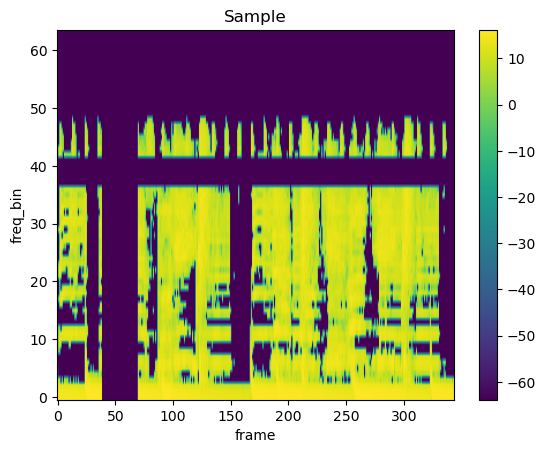

In [33]:
plot_spectrogram(d[0][0, 0, :, :], title='Sample')

# Models

## Simple classifier using CNN architecture

In [17]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv = nn.Sequential(self.conv1, self.relu1, self.bn1, self.conv2, self.relu2, self.bn2)
        
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=16, out_features=10)

    def forward(self, x):
        x = self.conv(x)
        
        x = self.ap(x)
        
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        
        return x

## Transfer learning using pretrained Mel-Spectrogram classifier
https://huggingface.co/docs/transformers/model_doc/audio-spectrogram-transformer

In [39]:
dataset = AudioDS(dataframe, pretrained=True)

# Random split of 80:20 between training and validation
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False)

In [6]:
class ASTSimpleTransfer(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ast_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        self.ast_model = ASTModel.from_pretrained('bookbot/distil-ast-audioset')
        self.ast_model = self.ast_model.to(device)
        
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(768, 100)
        self.relu2 = nn.ReLU()
        self.linear2 = nn.Linear(100, 10)
        
    def forward(self, x):
        with torch.no_grad():
            x = self.ast_model(**x).pooler_output
        
        x = self.relu1(x)
        x = self.linear1(x)
        x = self.relu2(x)
        x = self.linear2(x)
        
        return x

In [4]:
ast = ASTModel.from_pretrained('bookbot/distil-ast-audioset')

Some weights of the model checkpoint at bookbot/distil-ast-audioset were not used when initializing ASTModel: ['classifier.layernorm.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.layernorm.weight']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Training

In [340]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: %s" % device)

Using device: cpu


In [341]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct_prediction = 0
    total_prediction = 0
    
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm(dataloader, ascii=True)
        for i, (inputs, labels) in enumerate(progress_bar):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Normalize the inputs
#             inputs_m, inputs_s = inputs.mean(), inputs.std()
#             inputs = (inputs - inputs_m) / inputs_s
            
            outputs = model(inputs)
            
            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            progress_bar.set_description_str(
                "Batch: %d, Loss: %.4f" % ((i + 1), loss.item()))

    avg_loss = total_loss / len(dataloader)
    acc = correct_prediction / total_prediction
    return avg_loss, acc


In [476]:
# writer = SummaryWriter(log_dir="/content/drive/MyDrive/DL/DeepLearningProject/runs")

def checkpoint(model, optimizer, scheduler, epoch):
    checkpoint = {
      'epoch': epoch,
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
    }
    torch.save(checkpoint, f"/content/drive/MyDrive/DL/DeepLearningProject/checkpoint_{epoch}.pt")

def load_checkpoint(file, model, optimizer, scheduler):
      checkpoint = torch.load(file)
      model.load_state_dict(checkpoint['state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer'])
      scheduler.load_state_dict(checkpoint['scheduler'])
      return model, optimizer, checkpoint['epoch']


def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        model.train()
        print("-----------------------------------")
        print("Epoch %d" % (epoch+1))
        print("-----------------------------------")

        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        # Repeat for each batch in the training set
        progress_bar = tqdm(train_dl, ascii = True)
        for i, (inputs, labels) in enumerate(progress_bar):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Normalize the inputs
#             inputs_m, inputs_s = inputs.mean(), inputs.std()
#             inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs[0], inputs[1])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            progress_bar.set_description_str(
                "Batch: %d, Loss: %.4f" % ((i + 1), loss.item()))
          
        scheduler.step()

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        
        val_loss, val_acc = evaluate(model, val_dl, criterion)

        writer.add_scalar("Training loss", avg_loss, epoch)
        writer.add_scalar("Training accuracy", acc, epoch)
        writer.add_scalar("Validation loss", val_loss, epoch)
        writer.add_scalar("Validation accuracy", val_acc, epoch)
        writer.flush()

        print(f"Training Loss: {avg_loss:.2f} Accuracy: {acc:.2f}")
        print(f"Validation Loss: {val_loss:.2f} Accuracy: {val_acc:.2f}")

        checkpoint(model, optimizer, scheduler, epoch+1)
        
    print('Finished Training!')

In [ ]:
# model = CNNClassifier()
model = ASTSimpleTransfer()
model = model.to(device)

num_epochs = 20
training(model, train_dl, num_epochs)

Some weights of the model checkpoint at bookbot/distil-ast-audioset were not used when initializing ASTModel: ['classifier.layernorm.bias', 'classifier.layernorm.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Training Loss: 1.48 Accuracy: 0.65
Validation Loss: 0.96 Accuracy: 0.76
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Training Loss: 0.77 Accuracy: 0.80
Validation Loss: 0.70 Accuracy: 0.79
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/1199 [00:00<?, ?it/s]

In [ ]:
save_file = '/content/drive/MyDrive/DL/DeepLearningProject/transfer_learning.pt'
torch.save(model.state_dict(), save_file)

# Evaluate

In [47]:
model = ASTSimpleTransfer()
model.load_state_dict(torch.load('./transfer_learning.pt', map_location=torch.device('cpu')))
model = model.to(device)

Some weights of the model checkpoint at bookbot/distil-ast-audioset were not used when initializing ASTModel: ['classifier.layernorm.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.layernorm.weight']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# model.eval()
def inference(model, file, pretrained=False):
    model.eval()

    df = pd.DataFrame({'file': [file]})
    dataset = AudioDS(df, pretrained=pretrained, inference=True)
    loader = DataLoader(dataset, batch_size=1)

    for input in loader:
      input = input.to(device)
      output = model(input)
    output = output.to('cpu')
    _, prediction = torch.max(output,1)
    prediction = int(prediction)
    label = dataframe[dataframe['labelId'] == prediction].iloc[0].label

    print(f"Predicted Genre: {label}")

    return Audio(file)

# inference(model, "./data/audio/blues/blues.00000.wav", pretrained=True)
inference(model, "./test_data/kinda_metal.mp3", pretrained=True)
# Audio('./data/audio/blues/blues.00000.wav')

# Explainability

In [48]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        if (type(output) == tuple):
            output = output[0]
        activation[name] = output.detach()
    return hook

In [49]:
hooks = {}
for i in range(5):
    layer = model.ast_model.encoder.layer[0]
    hooks[f"embedding_{i}"] = layer.register_forward_hook(get_activation(f"embedding_{i}"))
hooks['relu1'] = model.relu1.register_forward_hook(get_activation('relu1'))
hooks['relu2'] = model.relu2.register_forward_hook(get_activation('relu2'))

In [50]:
activations = {}
for key in hooks.keys():
    activations[key] = None

In [52]:
# Look at activations at last layer and perform tSNE to visualize the clusters
loader = DataLoader(dataset, batch_size=16)
model.eval()
# model.ast_model.layernorm.register_forward_hook(get_activation('layernorm'))
# hook1 = model.relu1.register_forward_hook(get_activation('relu1'))
# hook2 = model.relu2.register_forward_hook(get_activation('relu2'))

# pretrained_activations = torch.empty(0, 768)
# last_activations = torch.empty(0, 100)
all_labels = torch.empty(0)
with torch.no_grad():
#     progress_bar = tqdm(loader, ascii=True)
    progress_bar = tqdm(val_dl, ascii=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device)
        model(inputs)
        
        for k, actv in activation.items():
            if activations[k] == None:
                activations[k] = actv
            else:
                activations[k] = torch.cat((activations[k], actv), dim=0)
#         pretrained_activation = activation['relu1'].to('cpu')
#         layer_activation = activation['relu2'].to('cpu')

#         pretrained_activations = torch.cat((pretrained_activations, pretrained_activation), dim=0)
#         last_activations = torch.cat((last_activations, layer_activation), dim=0)
        all_labels = torch.cat((all_labels, labels))


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
tsne_pretrained = TSNE(n_components=2)
z_pretrained = tsne_pretrained.fit_transform(pretrained_activations)

tsne_last = TSNE(n_components=2)
z_last = tsne_last.fit_transform(last_activations)

<ipython-input-67-9d2512f07164>:6: UserWarning: 
The palette list has fewer values (9) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df_expl.y.tolist(),


[Text(0.5, 1.0, 'Pretrained Output Layer Activation T-SNE Projection')]

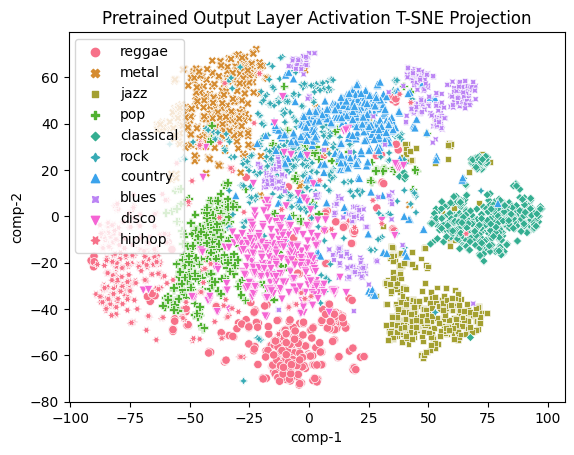

In [ ]:
df_expl = pd.DataFrame()
# df_expl["y"] = all_labels
df_expl["y"] = dataframe['label']
df_expl["comp-1"] = z_pretrained[:,0]
df_expl["comp-2"] = z_pretrained[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df_expl.y.tolist(),
                palette=sns.color_palette("husl", 9),
                data=df_expl,
                style=df_expl.y.tolist()).set(title="Pretrained Output Layer Activation T-SNE Projection")


<ipython-input-68-2ecfe3757033>:6: UserWarning: 
The palette list has fewer values (9) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df_expl.y.tolist(),


[Text(0.5, 1.0, 'Layer L-1 Activation T-SNE Projection')]

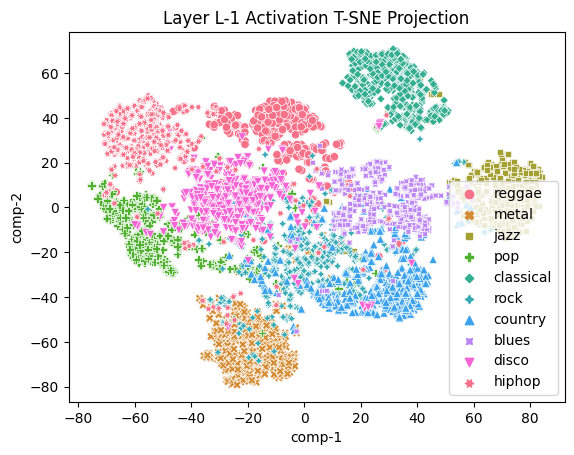

In [ ]:
df_expl = pd.DataFrame()
# df_expl["y"] = all_labels
df_expl["y"] = dataframe['label']
df_expl["comp-1"] = z_last[:,0]
df_expl["comp-2"] = z_last[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df_expl.y.tolist(),
                palette=sns.color_palette("husl", 9),
                data=df_expl,
                style=df_expl.y.tolist()).set(title="Layer L-1 Activation T-SNE Projection") 

# Fooling Audio

In [270]:
def preproc(file):
    audio, sr = librosa.load(file, sr=feature_extractor.sampling_rate)
    
    print(audio.shape, sr)
    # Funny business to get the shape to work correctly
    pretrained_feat = processor(audio, sampling_rate=sr, return_tensors="pt")
    feat_shape = pretrained_feat['input_values'].shape
#     pretrained_feat['input_values'] = pretrained_feat['input_values'].view(feat_shape[1], feat_shape[2])
    return pretrained_feat

In [271]:
from torch.autograd import Variable

def make_fooling(model, X, target_y):
    X_fooling = X.clone()
    X_fooling_var = Variable(X_fooling, requires_grad=True)
    
    learning_rate = 10  # learning rate is 1
    max_iter = 100  # maximum number of iterations

    for it in range(max_iter):
        pred = model({'input_values': X_fooling_var})
        print(pred)
        if torch.argmax(pred) == target_y:
            break

        class_pred = pred[0, target_y]
        class_pred.backward()

        grad = X_fooling_var.grad
        grad_norm = grad / torch.norm(grad)
        X_fooling_var.data += learning_rate * grad_norm
    return X_fooling.data

In [272]:
file = dataframe.iloc[0].file # Pop song
data = preproc(file)['input_values']
print(data.shape)
# make_fooling(model, data, 1)

(80000,) 16000
torch.Size([1, 1024, 128])


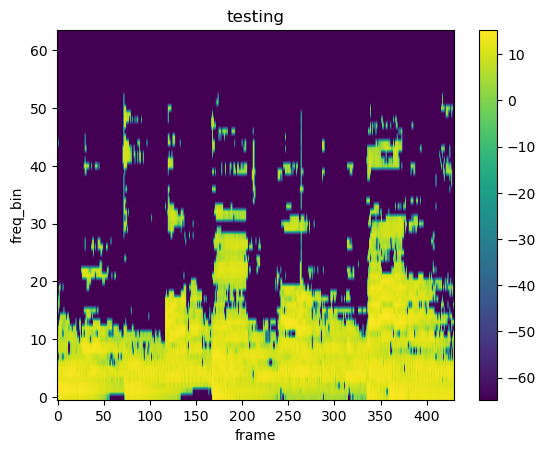

In [263]:
aud = AudioHelper.open(file)
reaud = AudioHelper.resample(aud, 44100)
rechan = AudioHelper.rechannel(reaud, 2)
dur_aud = AudioHelper.pad_trunc(rechan, 5000)

# shift_aud = AudioTransformations.time_shift(dur_aud, 0.4)
# sgram = AudioTransformations.spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
# aug_sgram = AudioTransformations.spectrogram_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

aug_sgram = AudioTransformations.spectrogram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)

plot_spectrogram(aug_sgram[0, :, :], title='testing', ylabel='freq_bin', aspect='auto', xmax=None)

In [266]:
aug_sgram.shape

torch.Size([2, 64, 430])

In [265]:
data.shape

torch.Size([1, 1024, 128])

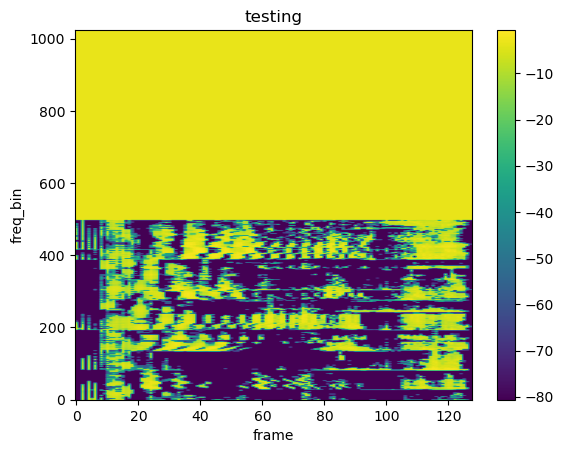

In [252]:
plot_spectrogram(data.view(data.shape[1], data.shape[2]), title='testing', ylabel='freq_bin', aspect='auto', xmax=None)

In [253]:
Audio(file)

# Style Transfer

In [171]:
def extract_features(model, x, layer_idx=[]):
    features = []
    prev_feat = x
    for i, module in enumerate(model._modules.values()):
        if i == 0:
            try:
                next_feat = module(**prev_feat).pooler_output
            except:
                next_feat = module(prev_feat).pooler_output
        else:
            next_feat = module(prev_feat)
        if i in layer_idx:
            features.append(next_feat)
        prev_feat = next_feat
    return features

In [172]:
def preproc(file):
    audio, sr = librosa.load(file, sr=feature_extractor.sampling_rate)

    # Funny business to get the shape to work correctly
    pretrained_feat = processor(audio, sampling_rate=sr, return_tensors="pt")
    feat_shape = pretrained_feat['input_values'].shape
#     pretrained_feat['input_values'] = pretrained_feat['input_values'].view(feat_shape[1], feat_shape[2])
    return pretrained_feat

In [193]:
content_file = dataframe.iloc[0].file
style_file = dataframe.iloc[-1].file

content_input = preproc(content_file)
style_input = preproc(style_file)

content_input_var = torch.autograd.Variable(content_input['input_values'].clone(), requires_grad=True)
style_input_var = torch.autograd.Variable(style_input['input_values'].clone(), requires_grad=True)

TypeError: 'retain_graph' is an invalid keyword argument for this function

In [194]:
src_content_feats = extract_features(model, content_input_var, [0])
src_style_feats = extract_features(model, style_input_var, [3])

In [196]:
# img = {'input_values': torch.Tensor(content_input['input_values'].shape).uniform_(0, 1)}
# img = torch.Tensor(content_input['input_values'].shape).uniform_(0, 1)
img = content_input['input_values'].clone()
img_var = torch.autograd.Variable(img, requires_grad=True)

initial_lr = 3.0
decayed_lr = 0.1
decay_lr_at = 180
optimizer = torch.optim.Adam([img_var], lr=initial_lr)

for t in range(10):
    content_feats = extract_features(model, img_var, [0])
    style_feats = extract_features(model, img_var, [3])
    
    optimizer.zero_grad()
    print('here')
    loss = ((content_feats[0] - src_content_feats[0])**2).mean() + ((style_feats[0] - src_style_feats[0])**2).mean()
    print(loss)
    loss.backward(retain_graph=True)
    
    if decay_lr_at == t:
        for g in optimizer.param_groups:
            g['lr'] = decayed_lr

    optimizer.step()

here
tensor(3.1871, grad_fn=<AddBackward0>)
here
tensor(5.3491, grad_fn=<AddBackward0>)
here
tensor(5.3007, grad_fn=<AddBackward0>)
here
tensor(5.3141, grad_fn=<AddBackward0>)
here
tensor(5.3147, grad_fn=<AddBackward0>)
here
tensor(5.3055, grad_fn=<AddBackward0>)
here
tensor(5.2899, grad_fn=<AddBackward0>)
here
tensor(5.2716, grad_fn=<AddBackward0>)
here
tensor(5.2524, grad_fn=<AddBackward0>)
here
tensor(5.2317, grad_fn=<AddBackward0>)


In [226]:
import numpy as np
out = img_var.detach().numpy()
# out.reshape(out.shape[1], out.shape[2])
S = np.abs(librosa.stft(out))
X_inv = librosa.griffinlim(S)

In [224]:
X_inv.shape

(1, 1024, 0)

In [225]:
X_inv

array([], shape=(1, 1024, 0), dtype=float32)

In [227]:
dataframe

,file,label,labelId
0,./data/samples/pop/10000_pop.00041.wav,pop,0
1,./data/samples/pop/10000_pop.00055.wav,pop,0
2,./data/samples/pop/10000_pop.00069.wav,pop,0
3,./data/samples/pop/10000_pop.00082.wav,pop,0
4,./data/samples/pop/20000_pop.00018.wav,pop,0
...,...,...,...
5989,./data/samples/jazz/5000_jazz.00033.wav,jazz,9
5990,./data/samples/jazz/5000_jazz.00027.wav,jazz,9
5991,./data/samples/jazz/20000_jazz.00039.wav,jazz,9
5992,./data/samples/jazz/20000_jazz.00005.wav,jazz,9


# Data pipeline in model

In [487]:
# audio, sr = librosa.load(file, sr=feature_extractor.sampling_rate)

class ASTPipeline(nn.Module):
    def __init__(self):
        super().__init__()
        self.processor = AutoProcessor.from_pretrained("bookbot/distil-ast-audioset")
    
    def forward(self, audio, sr):
        pretrained_feat = self.processor(audio, sampling_rate=self.processor.sampling_rate, return_tensors="pt")
        return pretrained_feat
    
class CNNPipeline(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, sr):
        aug_sgram = None
        for x_, sr_ in zip(x, sr):
            print(x_, sr_, x.shape, sr.shape)
            reaud = AudioHelper.resample(x_, sr_)
            rechan = AudioHelper.rechannel(reaud, 2)
            dur_aud = AudioHelper.pad_trunc(rechan, 5000)

            shift_aud = AudioTransformations.time_shift(dur_aud, 0.4)
            sgram = AudioTransformations.spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
            aug_sgram_out = AudioTransformations.spectrogram_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
            
            if aug_sgram is None:
                aug_sgram = aug_sgram_out
            else:
                print(aug_sgram_out)
        
        return aug_sgram

In [488]:
class CNNTransformer(nn.Module):
    def __init__(self):
        super().__init__()        
        # Pretrained transformer
        self.ast_pipeline = ASTPipeline()
        self.ast_model = ASTModel.from_pretrained('bookbot/distil-ast-audioset')
        self.ast_model = self.ast_model.to(device)
        
        for param in self.ast_model.parameters():
            param.requires_grad = False

        
        # CNN for pitch invariance
        self.cnn_pipeline = CNNPipeline()
        self.conv = nn.Conv2d(2, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(4)
        self.pool = nn.MaxPool2d((4,4))
        
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(768+608, 100)
        self.relu2 = nn.ReLU()
        self.linear2 = nn.Linear(100, 10)
        
    def forward(self, x, sr):
        x_pretrained = self.ast_pipeline(x, sr)
        x_pretrained = self.ast_model(**x_pretrained).pooler_output
        
        x_cnn = self.cnn_pipeline(x, sr)
        if len(x_cnn.shape) == 3:
            x_cnn = torch.unsqueeze(x_cnn, dim=0)
        x_cnn = self.conv(x_cnn)
        x_cnn = self.relu(x_cnn)
        x_cnn = self.bn(x_cnn)
        x_cnn = self.pool(x_cnn)
        x_cnn = x_cnn.view((x_cnn.shape[0], -1))

        x = torch.cat((x_cnn, x_pretrained), dim=1)
        x = self.relu1(x)
        x = self.linear1(x)
        x = self.relu2(x)
        x = self.linear2(x)
        
        return x
    
m = CNNTransformer()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at bookbot/distil-ast-audioset were not used when initializing ASTModel: ['classifier.layernorm.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.layernorm.weight']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [500]:
class CombinedDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = SAMPLE_LENGTH_MS
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file = self.df.loc[idx, 'file']
        audio, sr = librosa.load(file, sr=processor.sampling_rate)
        return audio, sr, self.df.loc[idx, 'labelId']

In [501]:
dataset = CombinedDataset(dataframe)

# Random split of 80:20 between training and validation
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [504]:
# writer = SummaryWriter(log_dir="/content/drive/MyDrive/DL/DeepLearningProject/runs")

def checkpoint(model, optimizer, scheduler, epoch):
    checkpoint = {
      'epoch': epoch,
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
    }
    torch.save(checkpoint, f"/content/drive/MyDrive/DL/DeepLearningProject/checkpoint_{epoch}.pt")

def load_checkpoint(file, model, optimizer, scheduler):
      checkpoint = torch.load(file)
      model.load_state_dict(checkpoint['state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer'])
      scheduler.load_state_dict(checkpoint['scheduler'])
      return model, optimizer, checkpoint['epoch']


def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        model.train()
        print("-----------------------------------")
        print("Epoch %d" % (epoch+1))
        print("-----------------------------------")

        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        # Repeat for each batch in the training set
        progress_bar = tqdm(train_dl, ascii = True)
        for i, (audio, sr, labels) in enumerate(progress_bar):
            # Get the input features and target labels, and put them on the GPU
            labels = labels.to(device)
            # Normalize the inputs
#             inputs_m, inputs_s = inputs.mean(), inputs.std()
#             inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(audio, sr)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            progress_bar.set_description_str(
                "Batch: %d, Loss: %.4f" % ((i + 1), loss.item()))
          
        scheduler.step()

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        
        val_loss, val_acc = evaluate(model, val_dl, criterion)

        writer.add_scalar("Training loss", avg_loss, epoch)
        writer.add_scalar("Training accuracy", acc, epoch)
        writer.add_scalar("Validation loss", val_loss, epoch)
        writer.add_scalar("Validation accuracy", val_acc, epoch)
        writer.flush()

        print(f"Training Loss: {avg_loss:.2f} Accuracy: {acc:.2f}")
        print(f"Validation Loss: {val_loss:.2f} Accuracy: {val_acc:.2f}")

        checkpoint(model, optimizer, scheduler, epoch+1)
        
    print('Finished Training!')

In [505]:
model = CNNTransformer()
model = model.to(device)

num_epochs = 20
training(model, train_dl, num_epochs)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at bookbot/distil-ast-audioset were not used when initializing ASTModel: ['classifier.layernorm.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.layernorm.weight']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/300 [00:00<?, ?it/s]

AssertionError: choose a window size 400 that is [2, 16]

In [286]:
p = ASTPipeline()
audio, sr = librosa.load(file)
p(audio, sr)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


{'input_values': tensor([[[ 0.1853, -0.0407,  0.3362,  ...,  0.2055,  0.1084,  0.1231],
         [ 0.2101, -0.0239,  0.3529,  ...,  0.0844, -0.0150,  0.0547],
         [ 0.2388, -0.0260,  0.3508,  ..., -0.2387, -0.1603, -0.0363],
         ...,
         [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670],
         [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670],
         [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670]]])}

In [283]:
p = CNNPipeline()
audio, sr = librosa.load(file, sr=feature_extractor.sampling_rate)
p(audio).shape

torch.Size([2, 64, 430])